In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase
import lsst.afw.table as afwTable
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection
import lsst.afw.display as afwDisplay
from skimage.filters import threshold_otsu
from sklearn.neighbors import NearestNeighbors

from lsst.geom import Extent2D, Point2D, SpherePoint
from lsst.geom import degrees as geomDeg
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load data

### Load image

In [2]:
repo_dir = '/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/test_output/blendTest_5/input/rerun/run1'
butler = dafPersist.Butler(repo_dir)

In [3]:
raft = 'R22'
detector = 'S11'
data_id = {'visit': 9006001, 'filter': 'g', 'raftName': raft, 'detectorName': detector}

In [4]:
raw = butler.get('postISRCCD', **data_id)

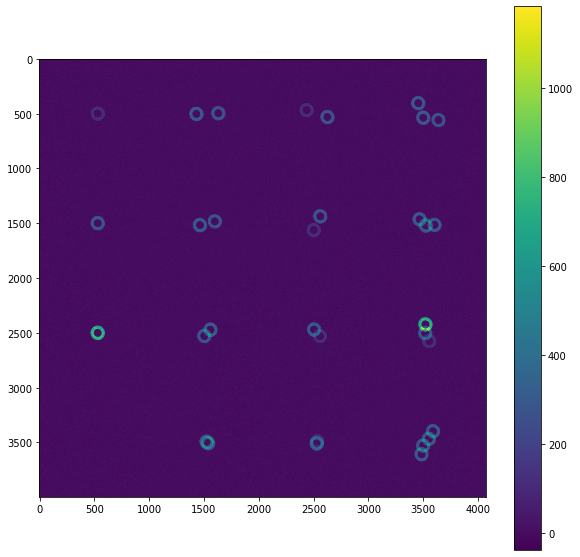

In [5]:
# Plot image array
fig = plt.figure(figsize=(10, 10))
plt.imshow(raw.image.array)
plt.colorbar()

In [76]:
from skimage.filters import threshold_local, try_all_threshold, threshold_triangle

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 1008x1440 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bf7fabe10>,
       dtype=object))

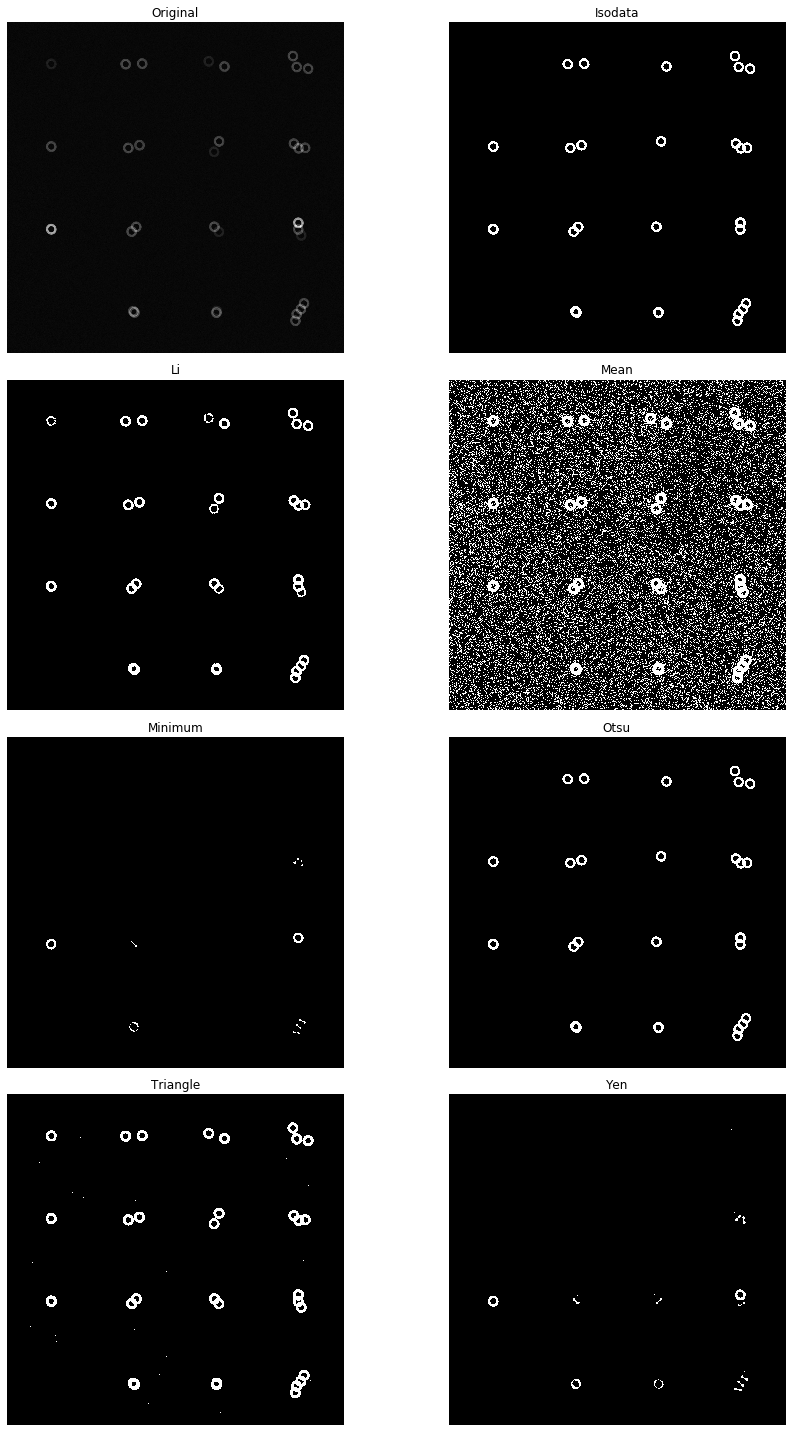

In [75]:
try_all_threshold(raw.image.array, figsize=(14, 20))

In [6]:
image_thresh = threshold_otsu(raw.image.array)
raw.image.array[raw.image.array <= image_thresh] = 0.
raw.image.array[raw.image.array > image_thresh] = 1.

In [78]:
image_thresh = threshold_triangle(raw.image.array)
raw.image.array[raw.image.array <= image_thresh] = 0.
raw.image.array[raw.image.array > image_thresh] = 1.

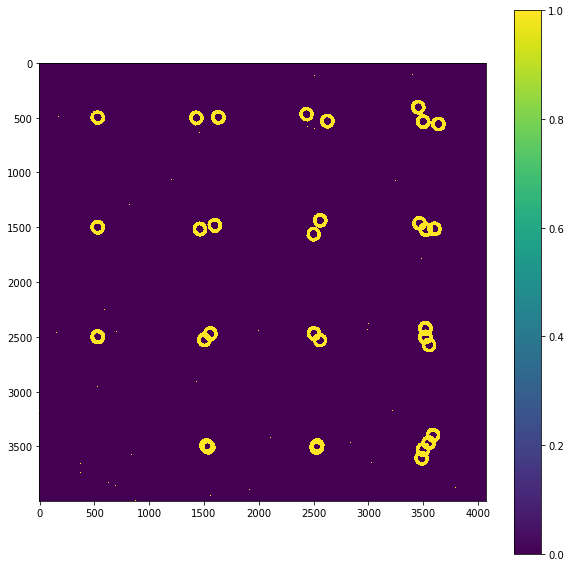

In [79]:
# Plot image array
fig = plt.figure(figsize=(10, 10))
plt.imshow(raw.image.array)
plt.colorbar()

### Load template

In [319]:
template_filename = os.path.join(os.environ['TS_WEP_DIR'], 'policy', 'deblend', 'data', 'extra_template-%s_%s.txt' % (raft, detector))

In [320]:
template_image = np.genfromtxt(template_filename)

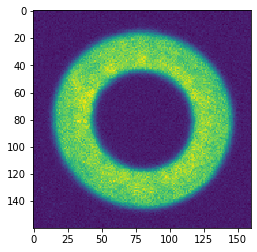

In [321]:
plt.imshow(template_image)

In [325]:
template_thresh = threshold_otsu(template_image)
binary_template = np.array(template_image)
binary_template[binary_template <= template_thresh] = 0.
binary_template[binary_template > template_thresh] = 1.

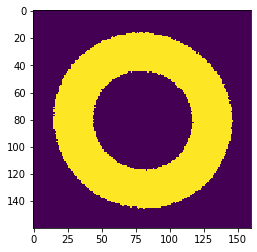

In [326]:
plt.imshow(binary_template)

## Run Centroid Finder

In [31]:
from lsst.ts.wep.deblend.BlendedImageDecorator import BlendedImageDecorator
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage

In [32]:
#convolution/correlation code for centroids
from lsst.afw.image import Image, Mask, MaskedImage, ImageF, MaskedImageF, ExposureF
from numpy.fft import fft2, ifft2
from scipy.signal import fftconvolve, correlate2d

def convolveExposureWithImage(exposure, kernelImage):
    '''Convolve image and variance planes in an exposure with an image using FFT
        Does not convolve mask. Returns new exposure'''
    
    newExposure = exposure.clone() 

    image = convolveImageWithImage(newExposure.getImage(), kernelImage)
    variance = convolveImageWithImage(newExposure.getVariance(), kernelImage)
    
    newExposure.image = image
    newExposure.variance = variance
    return newExposure

def convolveImageWithImage(image, kernelImage, conv=True, fft=True):
    '''Convolve/correlate an image with a kernel
        Option to use an FFT or direct (slow)
        Returns an image'''
    if conv:
        array = fftconvolve(image.getArray(), kernelImage.getArray(), mode='same')
    else:
        if fft:
            array = np.roll(ifft2(fft2(kernelImage.getArray()).conj()*fft2(image.getArray())).real, 
                         (image.getArray().shape[0] - 1)//2, axis=(0,1))
        else:
            array = correlate2d(image.getArray(), kernelImage.getArray(), mode='same')
    newImage = ImageF(array.shape[1], array.shape[0])
    newImage.array[:] = array
    return newImage

In [80]:
binary_template_image = ImageF(np.shape(template_image)[0], np.shape(template_image)[1])
binary_template_image.array[:] = binary_template
new_exp = convolveExposureWithImage(raw, binary_template_image)

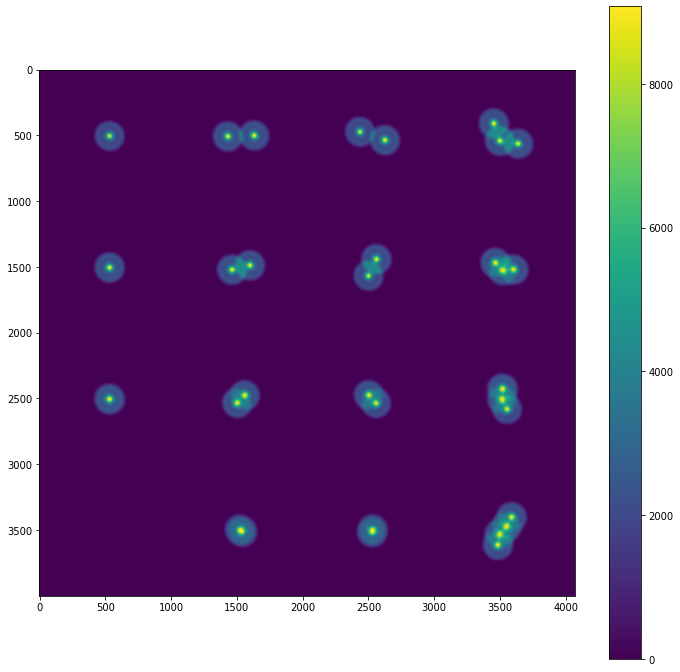

In [81]:
fig = plt.figure(figsize=(12,12))
plt.imshow(new_exp.image.array)
plt.colorbar()

## Rank results

### Test on input catalog

In [231]:
input_cat = np.genfromtxt('/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/starCatBlendTest.txt', names=True)

In [232]:
input_cat

array([( 0., -0.083333, -0.083333, 16.), ( 1., -0.027778, -0.083333, 15.),
       ( 2.,  0.027778, -0.083333, 14.), ( 3., -0.083519, -0.022225, 15.),
       ( 4., -0.083148, -0.03333 , 15.), ( 5., -0.028721, -0.024005, 15.),
       ( 6., -0.026835, -0.031551, 15.), ( 7.,  0.026196, -0.026217, 15.),
       ( 8.,  0.029359, -0.029339, 15.), ( 9.,  0.08295 , -0.02818 , 15.),
       (10.,  0.083717, -0.027376, 15.), (11., -0.085081,  0.022504, 16.),
       (12., -0.081585,  0.033051, 15.), (13., -0.031289,  0.02945 , 15.),
       (14., -0.024267,  0.026105, 16.), (15.,  0.02612 ,  0.026298, 15.),
       (16.,  0.029436,  0.029257, 16.), (17.,  0.082794,  0.027913, 16.),
       (18.,  0.083872,  0.027643, 15.), (19., -0.088628,  0.079086, 15.),
       (20., -0.081273,  0.081613, 15.), (21., -0.080099,  0.089302, 15.),
       (22., -0.029745,  0.079739, 15.), (23., -0.026635,  0.082914, 15.),
       (24., -0.026953,  0.087347, 15.), (25.,  0.023487,  0.082747, 14.),
       (26.,  0.02793 ,  

In [233]:
input_cat_df = pd.DataFrame(input_cat)

In [243]:
input_cat_df.head()

,Id,Ra,Decl,Mag
0,0.0,-0.083333,-0.083333,16.0
1,1.0,-0.027778,-0.083333,15.0
2,2.0,0.027778,-0.083333,14.0
3,3.0,-0.083519,-0.022225,15.0
4,4.0,-0.083148,-0.033330,15.0


In [84]:
from sklearn.neighbors import NearestNeighbors

In [85]:
X = input_cat[1:3].T*3600/.2

In [238]:
X = input_cat_df[['Ra', 'Decl']].values*3600/.2

In [252]:
input_cat_df['x_coord'] = X.T[1] + 2000.
input_cat_df['y_coord'] = X.T[0] + 2000.

In [86]:
nbrs = NearestNeighbors(n_neighbors=4).fit(X)

In [87]:
distances, indices = nbrs.kneighbors(X)

In [88]:
unblended = np.where(distances[:,1] > 126.)
blended = np.where(distances[:,1] <= 126.)

In [89]:
unblended, blended

((array([ 0,  1,  2,  3,  4,  5,  6, 11, 12, 13, 14, 19, 20, 21]),),
 (array([ 7,  8,  9, 10, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27, 28, 29, 30,
         31]),))

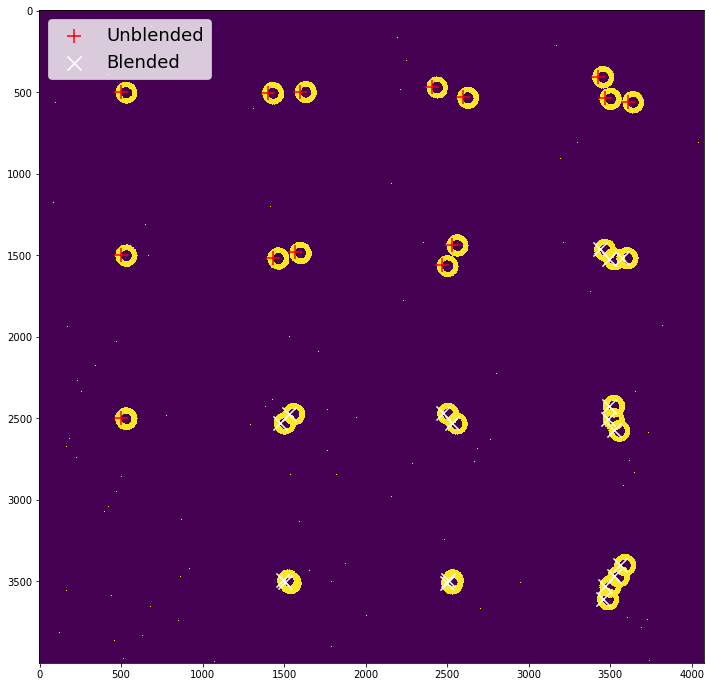

In [90]:
fig = plt.figure(figsize=(12,12))
plt.imshow(raw.image.array)
plt.scatter(X[unblended,1]+2000., X[unblended,0]+2000., c='r', s=200, marker='+', label='Unblended')
plt.scatter(X[blended,1]+2000., X[blended,0]+2000., c='white', s=200, marker='x', label='Blended')
plt.legend(fontsize=18)

Text(0.5, 1.0, 'Blendedness derived from catalog input')

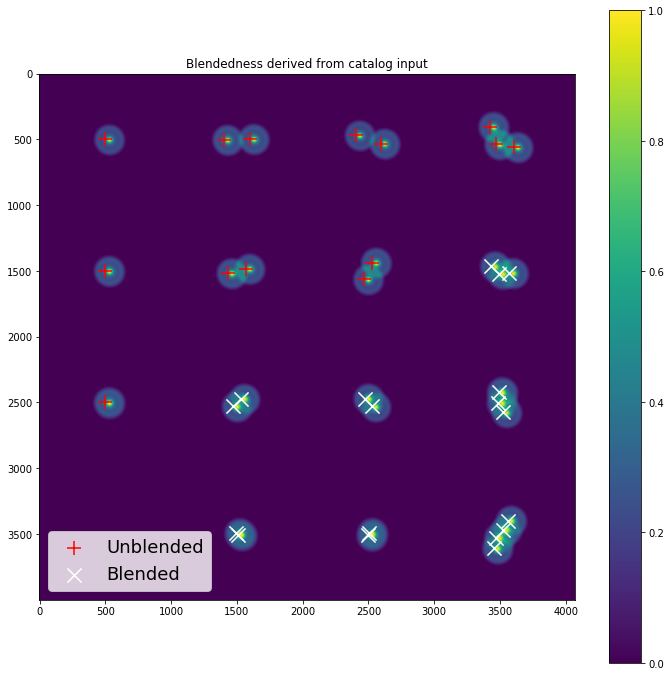

In [163]:
fig = plt.figure(figsize=(12,12))
plt.imshow(new_exp.image.array)
plt.scatter(X[unblended,1]+2000., X[unblended,0]+2000., c='r', s=200, marker='+', label='Unblended')
plt.scatter(X[blended,1]+2000., X[blended,0]+2000., c='white', s=200, marker='x', label='Blended')
plt.legend(fontsize=18)
plt.colorbar()
plt.title('Blendedness derived from catalog input')

### Detect blended objects using images

Here we convolve the image with our template donut and use the `DBSCAN` clustering method
to find the peaks in the convolved image. Then we measure the distance between these peaks
to identify objects that overlap and are blended.

In [93]:
ranked_convolve = np.argsort(new_exp.image.array.flatten())[::-1]
cutoff = len(np.where(new_exp.image.array.flatten() > 0.9*np.max(new_exp.image.array))[0])
ranked_convolve = ranked_convolve[:cutoff]
nx, ny = np.unravel_index(ranked_convolve, np.shape(new_exp.image.array))

In [100]:
from sklearn.cluster import DBSCAN

In [118]:
dbs = DBSCAN(eps=2.).fit(np.array([ny, nx]).T)

In [119]:
np.array([ny, nx]).T

array([[1529, 3499],
       [3468, 1469],
       [2563, 1445],
       ...,
       [ 543, 1501],
       [3511, 3531],
       [1439,  503]])

In [120]:
dbs.labels_

array([ 0,  1,  2, ..., 17, 21, 24])

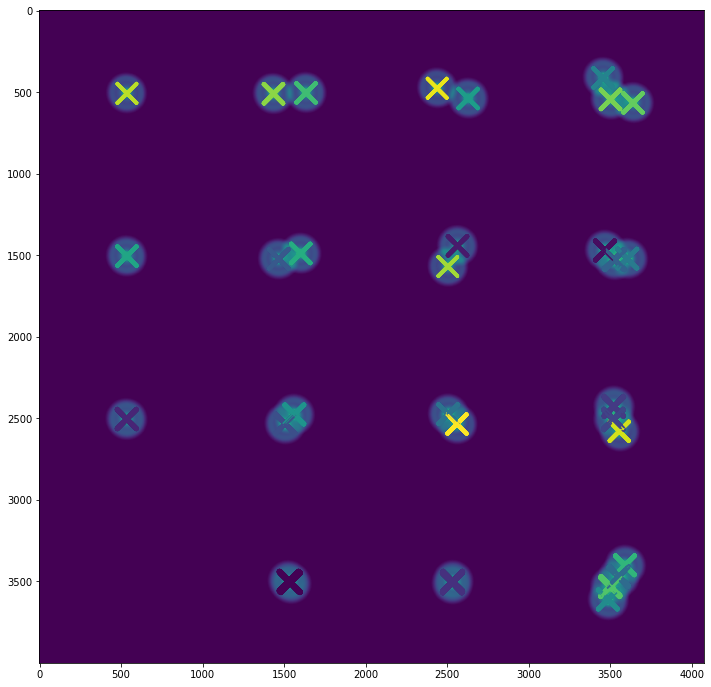

In [121]:
fig = plt.figure(figsize=(12,12))
plt.imshow(new_exp.image.array)
plt.scatter(ny, nx, c=dbs.labels_, marker='x', s=400)

In [122]:
np.unique(dbs.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [112]:
len(X)

32

In [127]:
dbs_cluster_centers = []
for i in np.unique(dbs.labels_):
    ny_cluster = ny[np.where(dbs.labels_ == i)]
    nx_cluster = nx[np.where(dbs.labels_ == i)]
    dbs_cluster_centers.append([np.mean(ny_cluster), np.mean(nx_cluster)])
dbs_cluster_centers = np.array(dbs_cluster_centers)

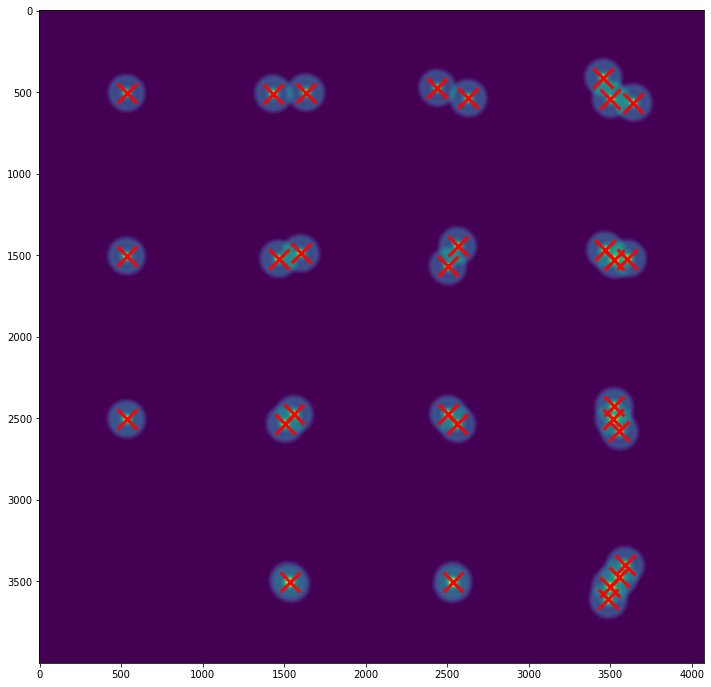

In [130]:
fig = plt.figure(figsize=(12,12))
plt.imshow(new_exp.image.array)
plt.scatter(dbs_cluster_centers[:,0], dbs_cluster_centers[:,1], c='r', marker='x', s=400, lw=3)

In [131]:
from scipy.spatial.distance import cdist

In [133]:
dist_matrix = cdist(dbs_cluster_centers, dbs_cluster_centers)

In [134]:
np.where(((dist_matrix > 0.) & (dist_matrix < 126.)))

(array([ 1,  5,  6,  6,  7,  9,  9, 10, 10, 11, 12, 14, 15, 19, 21, 21, 27,
        29]),
 array([ 9,  6,  5, 27, 15,  1, 12, 19, 21, 29,  9, 21,  7, 10, 10, 14,  6,
        11]))

In [136]:
dist_matrix_upper = np.triu(dist_matrix)

In [144]:
blended_pairs = np.array(np.where((dist_matrix_upper > 0.) & (dist_matrix_upper < 126.))).T

In [146]:
blended_cluster_centers = np.unique(blended_pairs.flatten())

In [157]:
unblended_cluster_centers = [j for j in range(len(dbs_cluster_centers)) if j not in blended_cluster_centers]

In [147]:
blended_cluster_centers

array([ 1,  5,  6,  7,  9, 10, 11, 12, 14, 15, 19, 21, 27, 29])

In [158]:
unblended_cluster_centers

[0, 2, 3, 4, 8, 13, 16, 17, 18, 20, 22, 23, 24, 25, 26, 28]

Text(0.5, 1.0, 'Detected using convolution and DBSCAN')

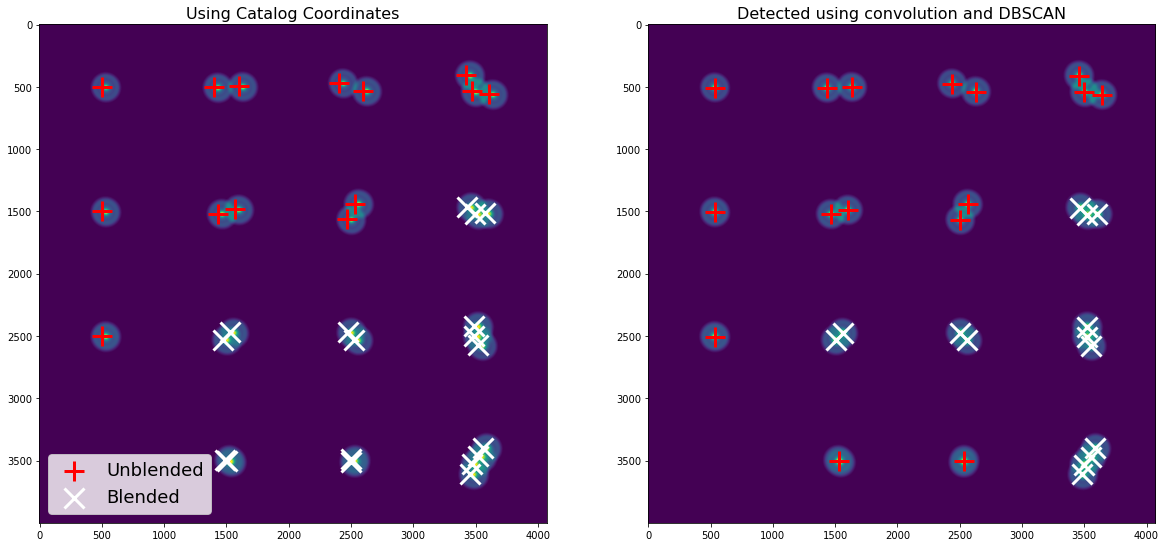

In [162]:
fig = plt.figure(figsize=(20,14))
fig.add_subplot(1,2,1)
plt.imshow(new_exp.image.array)
plt.scatter(X[unblended,1]+2000., X[unblended,0]+2000., c='r', s=400, marker='+', lw=3, label='Unblended')
plt.scatter(X[blended,1]+2000., X[blended,0]+2000., c='white', s=400, marker='x', lw=3, label='Blended')
plt.legend(fontsize=18)
#plt.colorbar()
plt.title('Using Catalog Coordinates', size=16)
fig.add_subplot(1,2,2)
plt.imshow(new_exp.image.array)
plt.scatter(dbs_cluster_centers[unblended_cluster_centers,0], 
            dbs_cluster_centers[unblended_cluster_centers,1], c='r', marker='+', s=400, lw=3)
plt.scatter(dbs_cluster_centers[blended_cluster_centers,0], 
            dbs_cluster_centers[blended_cluster_centers,1], c='w', marker='x', s=400, lw=3)
plt.title('Detected using convolution and DBSCAN', size=16)

### Calculate relative magnitudes of unblended objects

Get original image and use matched filter at locations of unblended objects to get a measure of the flux of each object.

In [166]:
im_raw = butler.get('postISRCCD', **data_id)

In [170]:
template_imageF = ImageF(np.shape(template_image)[0], np.shape(template_image)[1])
template_imageF.array[:] = template_image
rank_exp = convolveExposureWithImage(im_raw, template_imageF)

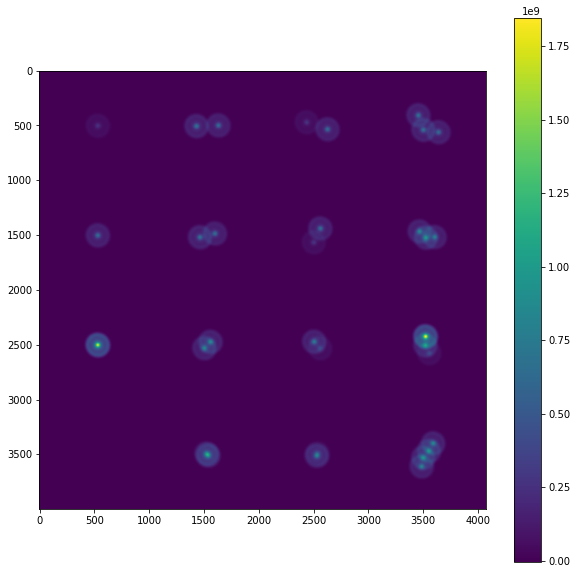

In [173]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(rank_exp.image.array)
plt.colorbar()

In [195]:
image_donuts_df = pd.DataFrame(dbs_cluster_centers, columns=['x_center', 'y_center'])

In [196]:
image_donuts_df['blended'] = False

In [197]:
image_donuts_df['blended'].iloc[blended_cluster_centers] = True

/astro/users/brycek/.local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [199]:
image_donuts_df['blended_with'] = None

In [200]:
blended_pairs

array([[ 1,  9],
       [ 5,  6],
       [ 6, 27],
       [ 7, 15],
       [ 9, 12],
       [10, 19],
       [10, 21],
       [11, 29],
       [14, 21]])

In [201]:
for i, j in blended_pairs:
    if image_donuts_df['blended_with'].iloc[i] is None:
        image_donuts_df['blended_with'].iloc[i] = []
    if image_donuts_df['blended_with'].iloc[j] is None:
        image_donuts_df['blended_with'].iloc[j] = []
    image_donuts_df['blended_with'].iloc[i].append(j)
    image_donuts_df['blended_with'].iloc[j].append(i)

/astro/users/brycek/.local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [202]:
image_donuts_df

,x_center,y_center,blended,blended_with
0,1534.211020,3503.698710,False,None
1,3467.368732,1470.914454,True,[9]
2,2563.078189,1443.176955,False,None
3,535.474255,2504.780488,False,None
4,2532.570259,3504.693042,False,None
5,3521.433921,2427.674009,True,[6]
6,3519.262097,2507.213710,True,"[5, 27]"
7,1506.317003,2533.573487,True,[15]
8,1466.564885,1523.160305,False,None
9,3524.107143,1527.369048,True,"[1, 12]"


In [203]:
unblended_df = image_donuts_df.query('blended == False')

In [209]:
unblended_flux = []
for x_coord, y_coord in zip(unblended_df['x_center'].values, unblended_df['y_center'].values):
    unblended_flux.append(rank_exp.image.array[np.int(y_coord), np.int(x_coord)])

In [212]:
unblended_flux

[1179953000.0,
 664177000.0,
 1756964200.0,
 824571900.0,
 699516300.0,
 684843700.0,
 648793400.0,
 665349570.0,
 646412000.0,
 644177150.0,
 645223500.0,
 683108000.0,
 696830800.0,
 271027230.0,
 264409940.0,
 272745020.0]

In [215]:
unblended_df['flux'] = unblended_flux

/astro/users/brycek/.local/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [220]:
unblended_df.sort_values('flux', ascending=False)

,x_center,y_center,blended,blended_with,flux
3,535.474255,2504.780488,False,None,1.756964e+09
0,1534.211020,3503.698710,False,None,1.179953e+09
4,2532.570259,3504.693042,False,None,8.245719e+08
8,1466.564885,1523.160305,False,None,6.995163e+08
24,1434.555118,510.649606,False,None,6.968308e+08
13,3455.696356,412.615385,False,None,6.848437e+08
23,3500.968872,544.595331,False,None,6.831080e+08
17,535.615970,1506.076046,False,None,6.653496e+08
2,2563.078189,1443.176955,False,None,6.641770e+08
16,2627.995781,539.063291,False,None,6.487934e+08


In [253]:
input_cat_df.iloc[unblended].sort_values('Mag')

,Id,Ra,Decl,Mag,x_coord,y_coord
2,2.0,0.027778,-0.083333,14.0,500.006,2500.004
1,1.0,-0.027778,-0.083333,15.0,500.006,1499.996
3,3.0,-0.083519,-0.022225,15.0,1599.950,496.658
4,4.0,-0.083148,-0.033330,15.0,1400.060,503.336
5,5.0,-0.028721,-0.024005,15.0,1567.910,1483.022
6,6.0,-0.026835,-0.031551,15.0,1432.082,1516.970
12,12.0,-0.081585,0.033051,15.0,2594.918,531.470
13,13.0,-0.031289,0.029450,15.0,2530.100,1436.798
19,19.0,-0.088628,0.079086,15.0,3423.548,404.696
20,20.0,-0.081273,0.081613,15.0,3469.034,537.086


The rankings match except for the two pairs of objects that our blend detector misidentifies as unblended when they are actually a blend with two object centers within 20 pixels of each other.

### Calculate number of donuts in blended systems

Get original image and use matched filter at locations of unblended objects to get a measure of the flux of each object.

In [254]:
blended_df = image_donuts_df.query('blended == True')

In [309]:
blended_df['blend_system'] = None

/astro/users/brycek/.local/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [310]:
blended_df

,x_center,y_center,blended,blended_with,blend_system,flux
1,3467.368732,1470.914454,True,[9],None,8.448794e+08
5,3521.433921,2427.674009,True,[6],None,1.842377e+09
6,3519.262097,2507.213710,True,"[5, 27]",None,1.112606e+09
7,1506.317003,2533.573487,True,[15],None,8.498612e+08
9,3524.107143,1527.369048,True,"[1, 12]",None,9.823023e+08
10,3551.100616,3471.114990,True,"[19, 21]",None,9.958147e+08
11,2506.540299,2475.002985,True,[29],None,7.541960e+08
12,3603.853035,1521.178914,True,[9],None,8.006546e+08
14,3485.348243,3611.092652,True,[21],None,8.156111e+08
15,1562.254958,2476.515581,True,[7],None,8.712513e+08


In [311]:
# Label blended systems
blended_system_list = []
num_systems = 0
for i, blended_list in list(enumerate(blended_df['blended_with'].values)):
    
    new_sys = True
    
    sys_on = blended_df.index[i]
    if blended_df['blend_system'].iloc[i] is None:
        for j in blended_list:
            if blended_df['blend_system'].loc[j] is not None:
                new_sys = False
                blended_sys_num = blended_df['blend_system'].loc[j]
    else:
        new_sys = False       
        blended_sys_num = blended_df.iloc[i]['blend_system']
        
    if new_sys is True:
        blended_system_list.append([sys_on])
        blended_df['blend_system'].iloc[i] = num_systems
        for j in blended_list:
            blended_system_list[-1].append(j)
            blended_df['blend_system'].loc[j] = num_systems
        num_systems += 1
    else:
        blended_system = blended_system_list[blended_sys_num]
        obj_blended = blended_df['blended_with'].iloc[i]
        for j in obj_blended:
            if j not in blended_system:
                blended_system.append(j)
                blended_df['blend_system'].loc[j] = blended_sys_num

/astro/users/brycek/.local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/astro/users/brycek/.local/lib/python3.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/astro/users/brycek/.local/lib/python3.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/astro/users/bry

In [312]:
blended_df

,x_center,y_center,blended,blended_with,blend_system,flux
1,3467.368732,1470.914454,True,[9],0,8.448794e+08
5,3521.433921,2427.674009,True,[6],1,1.842377e+09
6,3519.262097,2507.213710,True,"[5, 27]",1,1.112606e+09
7,1506.317003,2533.573487,True,[15],2,8.498612e+08
9,3524.107143,1527.369048,True,"[1, 12]",0,9.823023e+08
10,3551.100616,3471.114990,True,"[19, 21]",3,9.958147e+08
11,2506.540299,2475.002985,True,[29],4,7.541960e+08
12,3603.853035,1521.178914,True,[9],0,8.006546e+08
14,3485.348243,3611.092652,True,[21],3,8.156111e+08
15,1562.254958,2476.515581,True,[7],2,8.712513e+08


In [313]:
blended_flux = []
for x_coord, y_coord in zip(blended_df['x_center'].values, blended_df['y_center'].values):
    blended_flux.append(rank_exp.image.array[np.int(y_coord), np.int(x_coord)])

In [314]:
blended_df['flux'] = blended_flux

/astro/users/brycek/.local/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [315]:
blended_df

,x_center,y_center,blended,blended_with,blend_system,flux
1,3467.368732,1470.914454,True,[9],0,8.448794e+08
5,3521.433921,2427.674009,True,[6],1,1.842377e+09
6,3519.262097,2507.213710,True,"[5, 27]",1,1.112606e+09
7,1506.317003,2533.573487,True,[15],2,8.498612e+08
9,3524.107143,1527.369048,True,"[1, 12]",0,9.823023e+08
10,3551.100616,3471.114990,True,"[19, 21]",3,9.958147e+08
11,2506.540299,2475.002985,True,[29],4,7.541960e+08
12,3603.853035,1521.178914,True,[9],0,8.006546e+08
14,3485.348243,3611.092652,True,[21],3,8.156111e+08
15,1562.254958,2476.515581,True,[7],2,8.712513e+08


In [316]:
blend_system_df = pd.DataFrame(np.unique(blended_df['blend_system']), columns=['system_number'])

In [317]:
blend_system_df['system_size'] = np.bincount(blended_df['blend_system'])

In [318]:
blend_system_df

,system_number,system_size
0,0,3
1,1,3
2,2,2
3,3,4
4,4,2


## Test code 

In [7]:
from lsst.ts.wep.deblend.DonutDetector import DonutDetector

In [8]:
donut_detect = DonutDetector(raft, detector, 'extra')

In [9]:
donut_df = donut_detect.detectDonuts(raw)

/astro/users/brycek/.local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
donut_df

,x_center,y_center,blended,blended_with
0,3455.670732,412.589431,False,None
1,2532.586867,3504.720930,False,None
2,3519.264228,2507.233740,True,"[20, 27]"
3,3603.860390,1521.159091,True,[7]
4,1562.274566,2476.488439,True,[13]
5,2506.540299,2475.002985,True,[28]
6,1534.231132,3503.700472,False,None
7,3524.068273,1527.339357,True,"[3, 15]"
8,1602.153226,1489.310484,False,None
9,535.500000,2504.824176,False,None


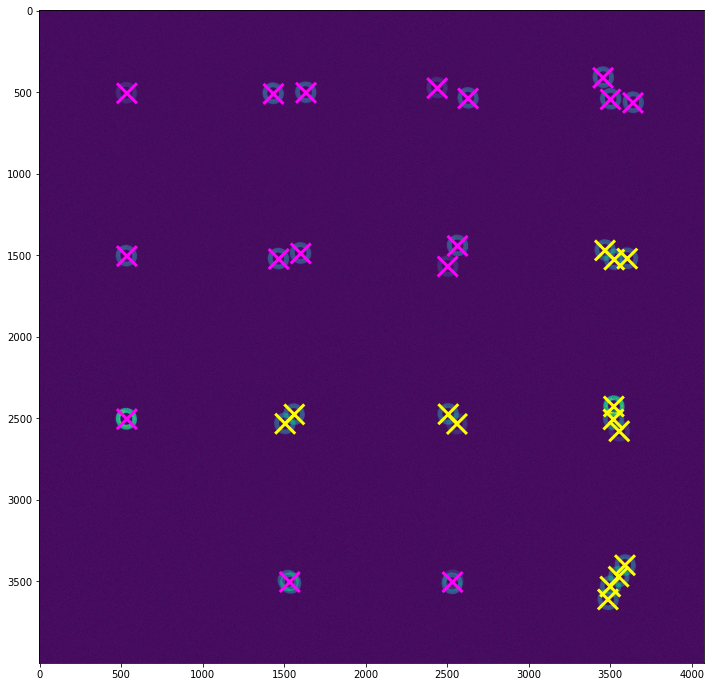

In [11]:
fig = plt.figure(figsize=(12,12))
plt.imshow(raw.image.array)
plt.scatter(donut_df['x_center'], donut_df['y_center'], c=donut_df['blended'], cmap=plt.get_cmap('spring'), marker='x', s=400, lw=3)

In [12]:
ranked_unblended_df = donut_detect.rankUnblendedByFlux(donut_df, raw)

/astro/store/epyc/users/brycek/Commissioning/aos/ts_wep/python/lsst/ts/wep/deblend/DonutDetector.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unblended_df['flux'] = unblended_flux


In [13]:
ranked_unblended_df

,x_center,y_center,blended,blended_with,flux
9,535.500000,2504.824176,False,None,1.753125e+09
6,1534.231132,3503.700472,False,None,1.168845e+09
1,2532.586867,3504.720930,False,None,8.170877e+08
21,1466.588462,1523.165385,False,None,6.979463e+08
23,1434.610442,510.658635,False,None,6.952927e+08
0,3455.670732,412.589431,False,None,6.834266e+08
11,3500.952569,544.541502,False,None,6.814547e+08
12,535.588462,1506.092308,False,None,6.638626e+08
17,2563.116183,1443.128631,False,None,6.628004e+08
22,2628.038793,539.060345,False,None,6.493003e+08


In [14]:
blended_df, blend_system_df = donut_detect.measureBlendCount(donut_df, raw)

/astro/store/epyc/users/brycek/Commissioning/aos/ts_wep/python/lsst/ts/wep/deblend/DonutDetector.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blended_df['blend_system'] = None
/astro/users/brycek/.local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/astro/store/epyc/users/brycek/Commissioning/aos/ts_wep/python/lsst/ts/wep/deblend/DonutDetector.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

In [15]:
blended_df

,x_center,y_center,blended,blended_with,blend_system
2,3519.264228,2507.233740,True,"[20, 27]",0
3,3603.860390,1521.159091,True,[7],1
4,1562.274566,2476.488439,True,[13],2
5,2506.540299,2475.002985,True,[28],3
7,3524.068273,1527.339357,True,"[3, 15]",1
10,3589.975309,3401.253086,True,[16],4
13,1506.395280,2533.495575,True,[4],2
14,3485.350482,3611.048232,True,[18],4
15,3467.350148,1470.899110,True,[7],1
16,3551.091286,3471.095436,True,"[10, 18]",4


In [16]:
blend_system_df

,system_number,system_size
0,0,3
1,1,3
2,2,2
3,3,2
4,4,4


## Test distances at which detector breaks down

### Load new image

In [17]:
repo_dir = '/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/test_output/blendTest_distance_2donuts_5/input/rerun/run1/'
butler = dafPersist.Butler(repo_dir)

In [18]:
raft = 'R22'
detector = 'S11'
data_id = {'visit': 9006001, 'filter': 'g', 'raftName': raft, 'detectorName': detector}

In [19]:
raw = butler.get('postISRCCD', **data_id)

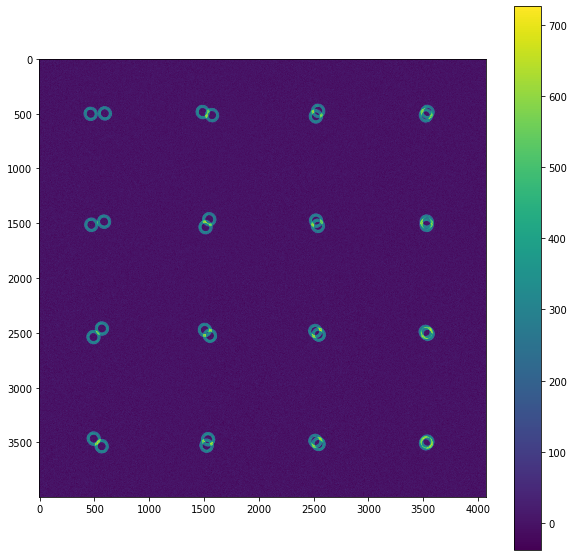

In [20]:
# Plot image array
fig = plt.figure(figsize=(10, 10))
plt.imshow(raw.image.array)
plt.colorbar()

### Run donut detector

In [21]:
donut_detect = DonutDetector(raft, detector, 'extra')

In [22]:
donut_df = donut_detect.detectDonuts(raw)

/astro/users/brycek/.local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [23]:
donut_df

,x_center,y_center,blended,blended_with
0,3531.687563,2505.003033,False,None
1,3531.619105,3503.894800,False,None
2,3531.754601,1506.360210,False,None
3,1557.731302,2531.418283,True,[15]
4,1576.549020,521.434641,True,[8]
5,1517.235988,1542.392330,True,[17]
6,592.077419,1491.906452,True,[10]
7,2525.633766,1483.877922,True,[20]
8,1492.074766,493.271028,True,[4]
9,2543.664835,482.978022,True,[24]


### Load input catalog

In [24]:
input_cat = np.genfromtxt('/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/starCatDistanceBlendSameMag.txt', names=True)

In [25]:
input_cat

array([( 0., -0.083454, -0.079724, 15.), ( 1., -0.083213, -0.086942, 15.),
       ( 2., -0.028586, -0.080099, 15.), ( 3., -0.02697 , -0.086567, 15.),
       ( 4.,  0.025603, -0.081187, 15.), ( 5.,  0.029952, -0.08548 , 15.),
       ( 6.,  0.081415, -0.085342, 15.), ( 7.,  0.085252, -0.081325, 15.),
       ( 8., -0.08412 , -0.030151, 15.), ( 9., -0.082547, -0.025405, 15.),
       (10., -0.029784, -0.026822, 15.), (11., -0.025772, -0.028734, 15.),
       (12.,  0.026327, -0.029072, 15.), (13.,  0.029229, -0.026483, 15.),
       (14.,  0.081717, -0.027373, 15.), (15.,  0.08495 , -0.028182, 15.),
       (16., -0.084736,  0.028384, 15.), (17., -0.081931,  0.027172, 15.),
       (18., -0.029091,  0.027327, 15.), (19., -0.026464,  0.028229, 15.),
       (20.,  0.026877,  0.026911, 15.), (21.,  0.028679,  0.028644, 15.),
       (22.,  0.082556,  0.026984, 15.), (23.,  0.084111,  0.028571, 15.),
       (24., -0.084206,  0.083761, 15.), (25., -0.08246 ,  0.082906, 15.),
       (26., -0.028611,  

In [26]:
input_cat_df = pd.DataFrame(input_cat)

In [27]:
input_cat_df.head()

,Id,Ra,Decl,Mag
0,0.0,-0.083454,-0.079724,15.0
1,1.0,-0.083213,-0.086942,15.0
2,2.0,-0.028586,-0.080099,15.0
3,3.0,-0.026970,-0.086567,15.0
4,4.0,0.025603,-0.081187,15.0


In [28]:
X = input_cat_df[['Ra', 'Decl']].values*3600/.2

In [29]:
input_cat_df['x_coord'] = X.T[1] + 2000.
input_cat_df['y_coord'] = X.T[0] + 2000.

In [30]:
nbrs = NearestNeighbors(n_neighbors=4).fit(X)

In [31]:
distances, indices = nbrs.kneighbors(X)

In [32]:
pair_distances = np.round(distances[:,1])

In [33]:
unblended = np.where(distances[:,1] > 126.)
blended = np.where(distances[:,1] <= 126.)

In [34]:
unblended, blended

((array([0, 1]),),
 (array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),))

Text(0.5, 1.0, 'True Blendedness')

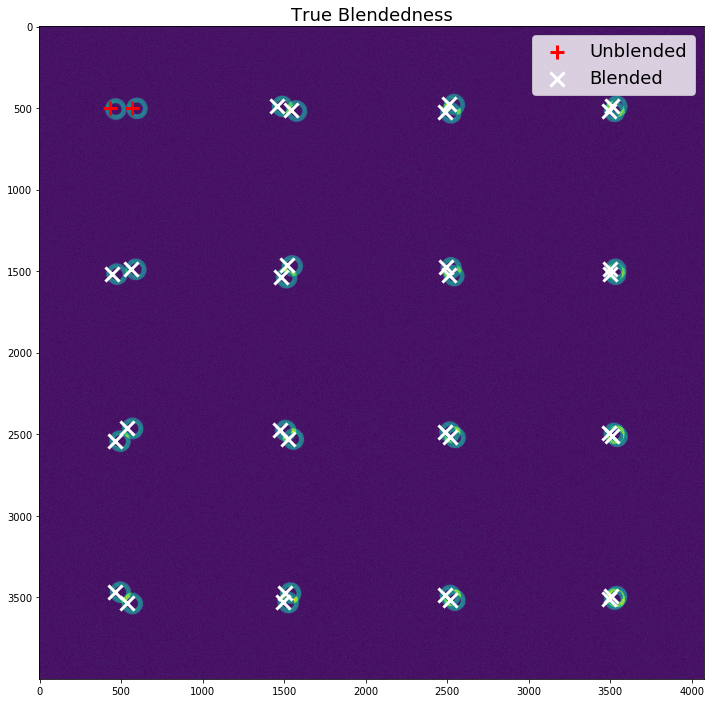

In [35]:
fig = plt.figure(figsize=(12,12))
plt.imshow(raw.image.array)
plt.scatter(X[unblended,1]+2000., X[unblended,0]+2000., c='r', s=200, marker='+', label='Unblended', lw=3)
plt.scatter(X[blended,1]+2000., X[blended,0]+2000., c='white', s=200, marker='x', label='Blended', lw=3)
plt.legend(fontsize=18)
plt.title('True Blendedness', size=18)

Text(0.5, 1.0, 'Donut Detector Blendedness')

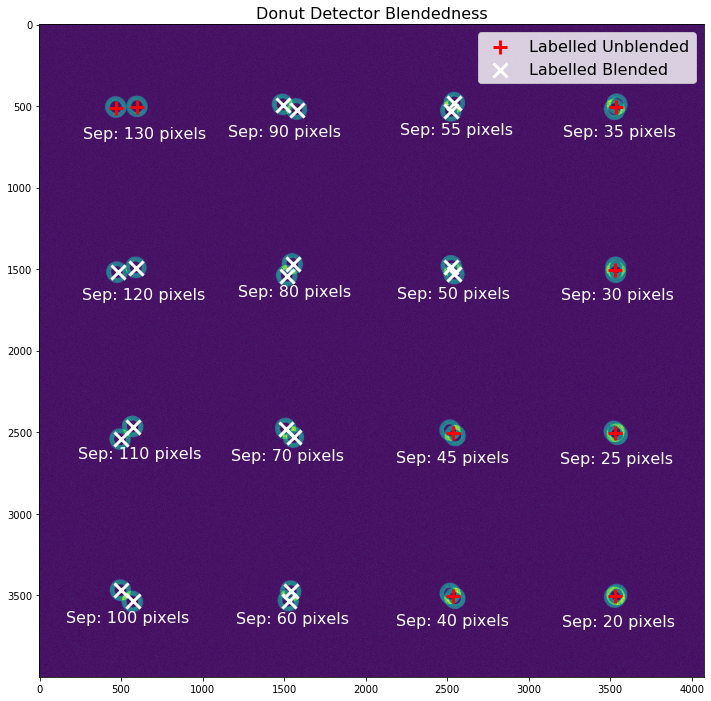

In [36]:
fig = plt.figure(figsize=(12,12))
plt.imshow(raw.image.array)
plt.scatter(donut_df.query('blended == False')['x_center'], donut_df.query('blended == False')['y_center'], c='r', s=200, marker='+', label='Labelled Unblended', lw=3)
plt.scatter(donut_df.query('blended == True')['x_center'], donut_df.query('blended == True')['y_center'], c='white', s=200, marker='x', label='Labelled Blended', lw=3)
plt.legend(fontsize=16)
for x_cent, y_cent, pair_sep in zip(input_cat_df['x_coord'].values[::2], input_cat_df['y_coord'].values[::2], pair_distances[::2]):
    plt.text(x_cent - 300., y_cent + 200., 'Sep: %i pixels' % pair_sep, c='w', size=16)
plt.title('Donut Detector Blendedness', size=16)

Current blend detector seems to break down between a separation of 45-50 pixels.